# Regressions

In [1]:
import time
import datetime
import bz2
from dateutil.relativedelta import relativedelta, MO

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


D:\apps\anaconda\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['MO']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
df = pd.read_csv('data_ML.csv', index_col=['date'], parse_dates=['date'], dayfirst=True)
df.head()

,open,high,low,close,volume,bb_bbh,bb_bbl,bb_bbm,ATR,ROCI_10,ROCI_20,ROCI_40,ROCI_60,ROCI_120,close_change
date,,,,,,,,,,,,,,,
2011-03-29,1.4086,1.4148,1.4047,1.4113,64044,1.411300,1.411300,1.411300,0.0,0.0,0.0,0.0,0.0,0.0,0
2011-03-30,1.4113,1.4146,1.4052,1.4126,70281,1.413250,1.410650,1.411950,0.0,0.0,0.0,0.0,0.0,0.0,1
2011-03-31,1.4127,1.4232,1.4116,1.4174,73492,1.419013,1.408520,1.413767,0.0,0.0,0.0,0.0,0.0,0.0,1
2011-04-01,1.4173,1.4245,1.4061,1.4234,70943,1.425675,1.406675,1.416175,0.0,0.0,0.0,0.0,0.0,0.0,1
2011-04-04,1.4231,1.4268,1.4192,1.4218,61094,1.426915,1.407685,1.417300,0.0,0.0,0.0,0.0,0.0,0.0,0


## Data preparation

In [3]:
X_train = df.copy(deep=True)
#X_train
X_train.drop(['close_change', 'close'],axis=1, inplace= True)
X_train.drop(X_train.index[-200:],inplace= True)
X_train = StandardScaler().fit_transform(X_train)
X_train

array([[ 1.54520257,  1.55398429,  1.55954407, ...,  0.09896004,
         0.11268251,  0.14391084],
       [ 1.56890717,  1.55223007,  1.56394739, ...,  0.09896004,
         0.11268251,  0.14391084],
       [ 1.58119844,  1.62766154,  1.6203099 , ...,  0.09896004,
         0.11268251,  0.14391084],
       ...,
       [-0.35581879, -0.38451665, -0.38645961, ..., -1.21604252,
        -1.1990735 ,  0.33180461],
       [-0.40647641, -0.42117985, -0.40002184, ..., -1.09321195,
        -1.04221651,  0.186191  ],
       [-0.4184165 , -0.37767519, -0.38223242, ..., -0.88074075,
        -0.90100462,  0.24363065]])

In [4]:
y_train = df['close_change'][:-200]
y_train

date
2011-03-29    0
2011-03-30    1
2011-03-31    1
2011-04-01    1
2011-04-04    0
             ..
2018-05-04    0
2018-05-07    0
2018-05-08    0
2018-05-09    0
2018-05-10    1
Name: close_change, Length: 1848, dtype: int64

In [5]:
X_test = df.copy(deep=True)
#X_train
X_test.drop(['close_change', 'close'],axis=1, inplace= True)
X_test.drop(X_test.index[:-200],inplace= True)
X_test = StandardScaler().fit_transform(X_test)
X_test

array([[ 2.41112476,  2.50259977,  2.5743682 , ..., -0.77957962,
        -0.52680289,  1.78400921],
       [ 2.58906825,  2.68143209,  2.8004434 , ..., -1.02537053,
        -0.36407393,  1.87529534],
       [ 2.48495238,  2.31552341,  2.11444444, ..., -1.03055589,
        -0.91165631,  1.7578128 ],
       ...,
       [-1.31433034, -1.46976069, -1.51441883, ...,  0.31799888,
         0.24619538, -0.05858548],
       [-1.72195974, -1.67078851, -1.58437906, ...,  0.42278325,
         0.75784282,  0.03520324],
       [-1.50615594, -1.75259478, -1.68154605, ...,  0.14490216,
         0.50003803, -0.00836477]])

In [6]:
y_test = df['close_change'][-200:].to_numpy()

## Logistic Regression 

In [7]:
def Log_regression(X_train,y_train,cv, C_list):
    scores= []
    for C in C_list:
        start_time = datetime.datetime.now()

        model = LogisticRegression(penalty='l2', C=C,solver='lbfgs', max_iter=10000)
        scores.append(cross_val_score(estimator=model, X=X_train,y=y_train,cv=cv,scoring="roc_auc"))

        print("\nCoefficient C=",C)
        print("Time've passed", datetime.datetime.now() - start_time)
        print("Kross validation score=", scores[-1])
        print("Mean=", np.mean(scores[-1]))
    print("best result is: ", max(np.mean(scores,axis = 1)))
    return scores

In [8]:
C_list = [0.01, 0.1, 1, 3, 5 ,10, 15, 20, 50, 100, 500, 1000, 10000]
cv = KFold(n_splits=5, shuffle=False)#, random_state=42)

In [9]:
scores_lr = Log_regression(X_train,y_train,cv, C_list)


Coefficient C= 0.01
Time've passed 0:00:00.070001
Kross validation score= [0.61509467 0.63894505 0.63074836 0.58243442 0.63335687]
Mean= 0.6201158756988467

Coefficient C= 0.1
Time've passed 0:00:00.110000
Kross validation score= [0.66389084 0.7170696  0.68702988 0.62519894 0.68908898]
Mean= 0.6764556474153165

Coefficient C= 1
Time've passed 0:00:00.190000
Kross validation score= [0.82407083 0.87021245 0.84121412 0.77264957 0.83680556]
Mean= 0.8289905066768494

Coefficient C= 3
Time've passed 0:00:00.260000
Kross validation score= [0.87000351 0.89934066 0.89398543 0.83905099 0.88965395]
Mean= 0.878406907187918

Coefficient C= 5
Time've passed 0:00:00.260001
Kross validation score= [0.88735975 0.90912821 0.91360137 0.86516357 0.90772128]
Mean= 0.8965948348055474

Coefficient C= 10
Time've passed 0:00:00.300000
Kross validation score= [0.90676134 0.91733333 0.93348279 0.88888889 0.92352283]
Mean= 0.9139978363377838

Coefficient C= 15
Time've passed 0:00:00.340001
Kross validation score

In [10]:
best_C = 1000

In [11]:
model = LogisticRegression(C=best_C).fit(X_train, y_train)
result = model.predict_proba(X_test)
y_pred =  model.predict(X_test)

In [12]:
result_pd = pd.Series(result[:, 1])
result_pd.describe()

count    2.000000e+02
mean     5.159996e-01
std      4.782282e-01
min      1.105695e-28
25%      3.600519e-06
50%      5.072243e-01
75%      9.999726e-01
max      1.000000e+00
dtype: float64

In [13]:
model.score(X_train, y_train)

0.8593073593073594

In [14]:
print("accuracy", accuracy_score(y_test, y_pred)) 
print("precision", precision_score(y_test,y_pred))
print("recall", recall_score(y_test,y_pred))

accuracy 0.865
precision 0.86
recall 0.8686868686868687


## Rigle Regression

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack

In [16]:
y_train_lineral =  df['close'][:-200]
#StandardScaler().fit_transform(X_test)

In [17]:
alpha_list = [0.01, 0.1, 1, 3, 5 ,10, 15, 20, 50, 100, 500, 1000, 10000,50000,100000]

In [18]:
def plot_rigle(df):
    df2 = df[['WAG_C_M']]
    date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
    future = pd.DataFrame(index=date_list, columns= df2.columns)
    df2 = pd.concat([df2, future])
    df2['forecast'] = invboxcox(best_model.predict(start=284, end=317), lmbda)

    plt.figure(figsize(15,7))
    df_copy.WAG_C_M.plot()
    df2.forecast.plot(color='r')
    plt.ylabel('close')
    pylab.show()

In [19]:
date_list = [datetime.datetime.strptime("2018-05-11", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,250)]
#date_list

In [20]:
#df.index[-200:].to_datetime()
pd.to_datetime(df.index[-200:])

DatetimeIndex(['2018-05-11', '2018-05-14', '2018-05-15', '2018-05-16',
               '2018-05-17', '2018-05-18', '2018-05-21', '2018-05-22',
               '2018-05-23', '2018-05-24',
               ...
               '2019-02-04', '2019-02-05', '2019-02-06', '2019-02-07',
               '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15'],
              dtype='datetime64[ns]', name='date', length=200, freq=None)

In [21]:
df_y_text_dt = df.index[-200:].to_list()


Coefficient alpha= 0.01
Time've passed 0:00:00.010000
[1.53979969 1.55556184 1.4776454  1.44198065 1.44812761 1.42932606
 1.40847161 1.43317694 1.3744328  1.3939321  1.34649356 1.33449498
 1.26646186 1.32570443 1.3546469  1.32678538 1.37095544 1.34795244
 1.40049973 1.42868704 1.3818492  1.41945771 1.39237588 1.39804789
 1.31086659 1.29042809 1.28952322 1.26442739 1.25850804 1.26686284
 1.32201671 1.32996959 1.32220519 1.26939    1.27213478 1.32558642
 1.29674051 1.31806925 1.31967371 1.34618683 1.36971651 1.38558634
 1.34895711 1.33603221 1.33076076 1.30720636 1.35070051 1.33713513
 1.29781809 1.29854273 1.35212725 1.34958509 1.33519775 1.35792159
 1.32900223 1.31622135 1.35090376 1.36335737 1.33386079 1.28966684
 1.27890089 1.24993152 1.28398395 1.28612023 1.25097907 1.17161671
 1.16986373 1.13058926 1.10711736 1.14883683 1.16697892 1.17457813
 1.25429786 1.26456364 1.2318961  1.28146067 1.30499883 1.3348766
 1.31316083 1.30647893 1.27587973 1.28002255 1.23425264 1.26596502
 1.28921

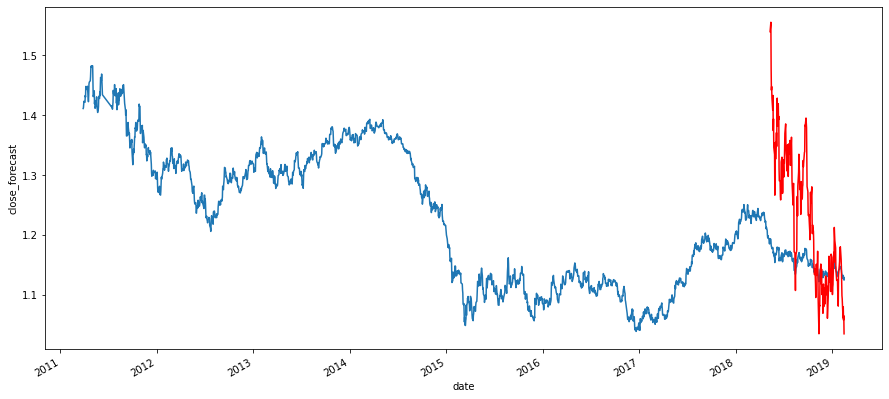


Coefficient alpha= 0.1
Time've passed 0:00:00
[1.5396416  1.55450627 1.48030413 1.44454135 1.44899423 1.4305728
 1.41042563 1.43364928 1.37744104 1.39376175 1.34865474 1.33623736
 1.27055724 1.32502767 1.35430037 1.32819669 1.36903694 1.34815654
 1.39837034 1.42573019 1.38209183 1.41701408 1.3919048  1.39640446
 1.31402999 1.29072191 1.28993977 1.26660088 1.26003605 1.26748782
 1.32025844 1.32921961 1.32276672 1.27123557 1.2726952  1.32374116
 1.29804213 1.31757946 1.31923385 1.34413927 1.36695925 1.38258347
 1.34855262 1.33614626 1.33027339 1.30784734 1.34942096 1.3369398
 1.29907951 1.29933554 1.34995154 1.34880614 1.33475957 1.3568493
 1.3301851  1.31640454 1.3495863  1.36226062 1.33421977 1.29159477
 1.27943077 1.25168227 1.28349046 1.28624415 1.25313092 1.17600564
 1.17090946 1.13397959 1.11038071 1.14965621 1.16718652 1.17546055
 1.25135644 1.26245593 1.23221608 1.27853982 1.30224787 1.3317342
 1.3117344  1.30557883 1.27575605 1.27824166 1.2351013  1.26439846
 1.28748055 1.25849

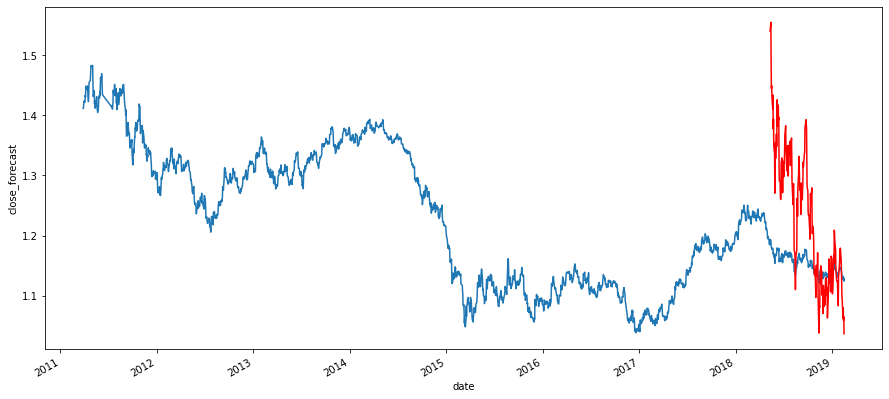


Coefficient alpha= 1
Time've passed 0:00:00
[1.53882101 1.54915056 1.4937774  1.45752609 1.45340109 1.43689689
 1.42032795 1.43604052 1.39268199 1.39288344 1.35962    1.34502183
 1.29128609 1.32140362 1.35252443 1.33535215 1.35926191 1.34920467
 1.38754018 1.41074799 1.38336824 1.40466023 1.38954552 1.38806818
 1.32988951 1.29217714 1.29206698 1.27761028 1.26782227 1.2705903
 1.3113165  1.32541741 1.32564531 1.28056975 1.27552519 1.31425449
 1.30466146 1.3151347  1.31705159 1.3337544  1.35295291 1.3673929
 1.34655594 1.33675778 1.32785068 1.31112527 1.34296759 1.33594566
 1.30551588 1.30332415 1.33883166 1.34489575 1.33256906 1.35139686
 1.33618298 1.31736586 1.34287654 1.35670425 1.33608898 1.30137817
 1.28213292 1.26060302 1.28096334 1.2868839  1.26404178 1.19820814
 1.17616876 1.15114703 1.12694459 1.15376632 1.16819301 1.17990747
 1.23633394 1.25178863 1.23390486 1.26365877 1.28827179 1.31583127
 1.30458283 1.30108463 1.27516159 1.26927451 1.23945706 1.25644117
 1.27875212 1.25734

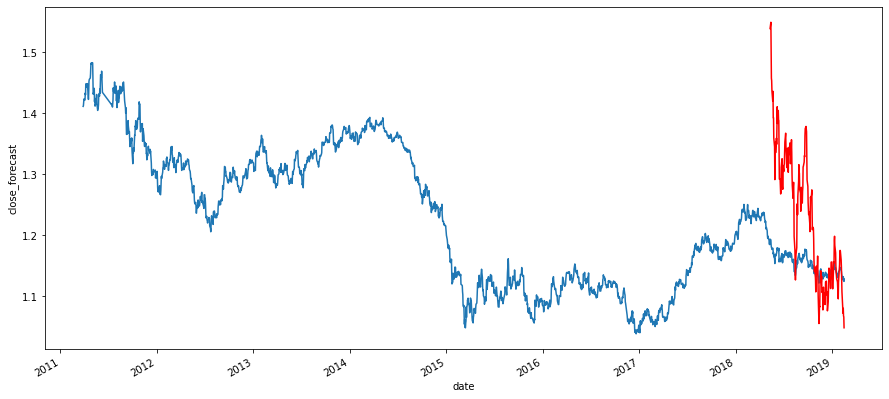


Coefficient alpha= 3
Time've passed 0:00:00
[1.53823471 1.54582302 1.50199493 1.46541619 1.45604544 1.44071798
 1.42632893 1.43745119 1.40196825 1.39225763 1.36631408 1.35033176
 1.30389757 1.31889594 1.35138456 1.33973186 1.35320631 1.34985547
 1.38086541 1.40159706 1.3842347  1.39714788 1.38814899 1.38296313
 1.3395255  1.29299302 1.29336658 1.28435035 1.27262464 1.27241534
 1.30579762 1.3231055  1.3274694  1.28629641 1.27720699 1.30827299
 1.30876659 1.31367729 1.31577939 1.32739935 1.34437516 1.35817112
 1.34544293 1.33721738 1.32641827 1.31317664 1.33905926 1.33535986
 1.30949823 1.30572662 1.33191556 1.34257933 1.33127572 1.34803511
 1.33988601 1.31797113 1.33872558 1.35330278 1.33727443 1.30737961
 1.28377291 1.26608559 1.27935218 1.28726311 1.27072464 1.21172752
 1.17924877 1.16159509 1.13702866 1.15615538 1.16870297 1.18258289
 1.22700946 1.24530272 1.23504818 1.2544701  1.27972303 1.30617005
 1.30033636 1.29846341 1.27488794 1.26386946 1.242229   1.25157812
 1.27349686 1.256

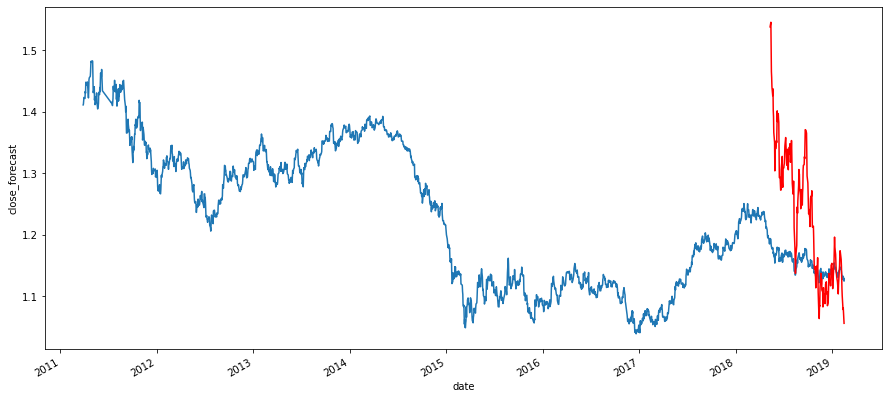


Coefficient alpha= 5
Time've passed 0:00:00
[1.53797668 1.54467326 1.50468913 1.4679772  1.45686715 1.44194
 1.42827089 1.43787232 1.40501093 1.39198612 1.36851308 1.35206852
 1.30803596 1.31794489 1.35097492 1.34118415 1.35117001 1.35007037
 1.37863192 1.39856666 1.38455684 1.39467161 1.38769892 1.38126452
 1.34275606 1.29322927 1.29379611 1.28659481 1.27423131 1.27300396
 1.30395069 1.32235325 1.32810528 1.28822117 1.27773508 1.30622505
 1.31016184 1.31320688 1.31538544 1.32529495 1.34154106 1.35515112
 1.34512666 1.33741194 1.32595432 1.31387579 1.33777469 1.3351803
 1.31082774 1.30650587 1.32957998 1.34184865 1.33086596 1.34690679
 1.34113444 1.31816842 1.33733178 1.3521668  1.33766849 1.3093728
 1.28429806 1.26790079 1.27878377 1.28737014 1.27294071 1.21617404
 1.18018585 1.16502909 1.1403259  1.15687529 1.1688172  1.18345144
 1.22387263 1.24317156 1.23547087 1.25139352 1.276902   1.30299521
 1.29897344 1.29764335 1.2748364  1.2621053  1.24319539 1.24997284
 1.27178091 1.25650938

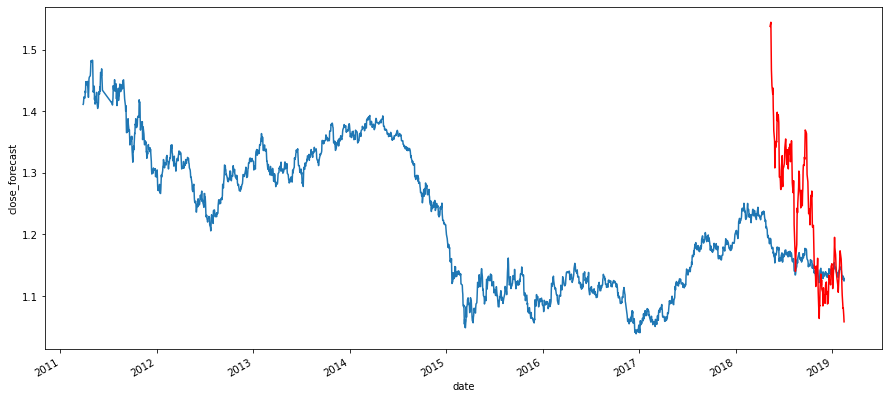


Coefficient alpha= 10
Time've passed 0:00:00
[1.53763441 1.54354282 1.50703976 1.4701802  1.45750927 1.4429654
 1.42994561 1.43816599 1.40767511 1.39164755 1.37045683 1.35361461
 1.31170391 1.31696603 1.35056375 1.34249303 1.3493117  1.3502574
 1.37658789 1.39581858 1.38486421 1.39243876 1.38727817 1.37970649
 1.34572586 1.29341934 1.29420692 1.28864113 1.27571421 1.27354052
 1.30228036 1.32170236 1.32871317 1.2900039  1.27818467 1.30431754
 1.31147141 1.3128039  1.31507319 1.32340188 1.3390024  1.3524639
 1.34489296 1.33761689 1.32553499 1.31452302 1.3366173  1.33502177
 1.31202334 1.30717723 1.32741739 1.34122795 1.33051301 1.34586355
 1.34227377 1.31833889 1.33605892 1.35111319 1.33800085 1.31116369
 1.28474551 1.26953759 1.27823763 1.28743003 1.27492818 1.22011401
 1.18092869 1.16810157 1.14325171 1.15744354 1.16886453 1.18422426
 1.22099407 1.24126079 1.23587978 1.24857325 1.27436234 1.30012792
 1.29774861 1.29691146 1.27479323 1.26053149 1.24409955 1.24851731
 1.27022974 1.25634

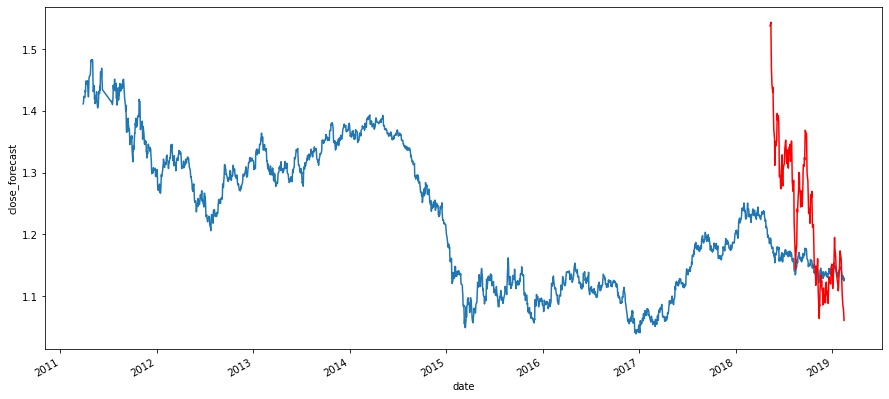


Coefficient alpha= 15
Time've passed 0:00:00.010000
[1.5374202  1.54304023 1.50783392 1.47090915 1.45766986 1.44328802
 1.4305123  1.43820399 1.40859125 1.39145853 1.37114706 1.35418269
 1.31302164 1.31654569 1.35038499 1.34297812 1.34861665 1.35031916
 1.3758044  1.39477083 1.3849667  1.39159495 1.38708766 1.37909522
 1.34685211 1.29349247 1.29439613 1.28942155 1.27630168 1.27376038
 1.3016689  1.32148302 1.32895569 1.2907019  1.27834598 1.3035817
 1.31199448 1.31267315 1.31499116 1.32270061 1.33806826 1.35147626
 1.34482421 1.33768962 1.32536922 1.31476818 1.3361782  1.33494986
 1.31245619 1.30739802 1.32657138 1.34101246 1.33038622 1.34545208
 1.34269251 1.31839815 1.33557922 1.35068861 1.33809455 1.31181679
 1.28489697 1.27015329 1.2780229  1.28742203 1.27565099 1.22151501
 1.1811506  1.16924214 1.14432685 1.15761759 1.1688611  1.18451583
 1.21989352 1.24054613 1.2360285  1.24748601 1.27340596 1.29902573
 1.29725542 1.29660077 1.27474021 1.2599451  1.24443393 1.24795526
 1.2696232

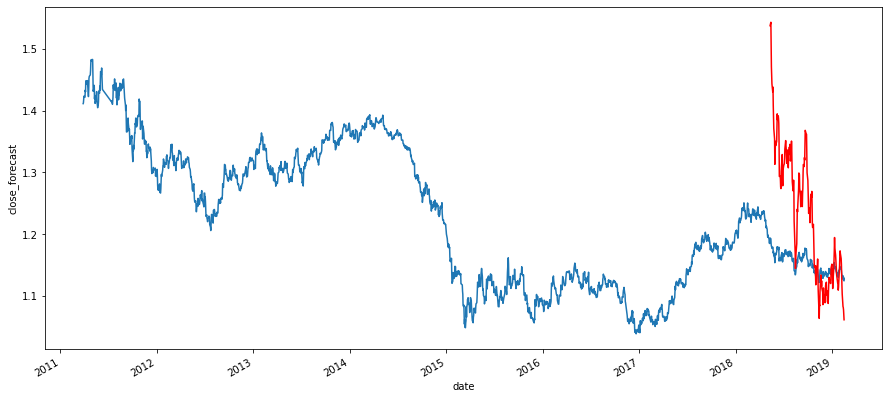


Coefficient alpha= 20
Time've passed 0:00:00
[1.53724932 1.5427188  1.50818715 1.47122635 1.45770104 1.44341757
 1.43077207 1.4381744  1.40901435 1.39132166 1.37148476 1.35447775
 1.31368004 1.3163031  1.35027683 1.34322954 1.34825585 1.35034494
 1.37537907 1.39420039 1.38500174 1.39113943 1.38695587 1.37874955
 1.3474434  1.29354022 1.29452645 1.28984236 1.27663637 1.27389452
 1.30136115 1.32138372 1.32908869 1.2910884  1.27843215 1.30318717
 1.31228954 1.31261844 1.31497106 1.32233535 1.33758491 1.3509611
 1.344791   1.33771383 1.32527217 1.3148953  1.33593897 1.33489664
 1.31267045 1.30749165 1.32610164 1.34090386 1.33031924 1.34521958
 1.34290087 1.3184269  1.3353264  1.35044057 1.33811864 1.31214576
 1.28496837 1.27048265 1.27790884 1.28739706 1.27601423 1.22219958
 1.18124098 1.16984359 1.14489046 1.15769468 1.1688548  1.18467618
 1.21930198 1.24016523 1.23609412 1.24689114 1.27289195 1.29841282
 1.29695617 1.29639479 1.27467165 1.25963268 1.24459639 1.24764186
 1.26927626 1.256

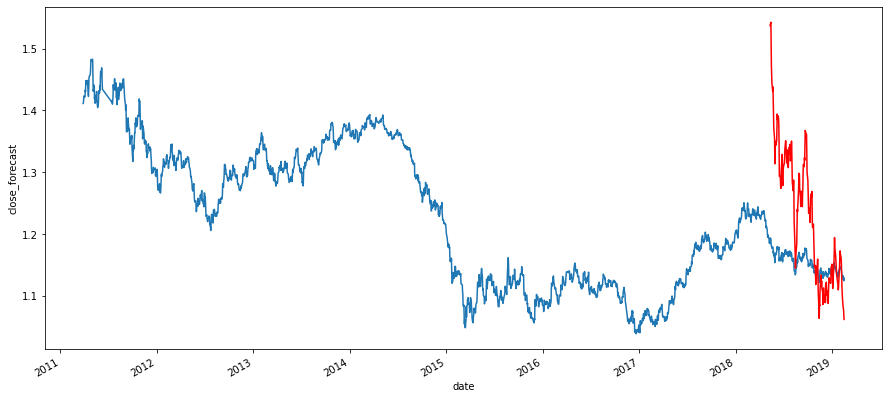


Coefficient alpha= 50
Time've passed 0:00:00.010000
[1.53645095 1.54161977 1.50833008 1.47131337 1.45734213 1.44335605
 1.43098478 1.43771875 1.40935582 1.39077996 1.37193831 1.35503123
 1.31470291 1.31572839 1.34996036 1.34367851 1.34760041 1.35032816
 1.3744325  1.39289653 1.38486193 1.39011848 1.38639842 1.37785287
 1.34851894 1.29373407 1.29504097 1.29073556 1.27749872 1.27431781
 1.30088159 1.32130162 1.32935624 1.29197487 1.27863131 1.30238362
 1.31299417 1.31261025 1.31509406 1.32163266 1.33667752 1.34993905
 1.34468827 1.33758392 1.32497641 1.31510005 1.33537776 1.33462991
 1.31295886 1.30748312 1.32498436 1.34068597 1.33015802 1.34462321
 1.34317229 1.31845979 1.33482933 1.34973795 1.337944   1.31265506
 1.28505376 1.27118232 1.2777047  1.28718735 1.27657657 1.22312087
 1.18127713 1.17107242 1.14604077 1.15779885 1.16886372 1.18507549
 1.21807041 1.23936061 1.23608033 1.24554679 1.27176849 1.29689307
 1.29598325 1.29557626 1.27414739 1.25896568 1.24476012 1.24686522
 1.268337

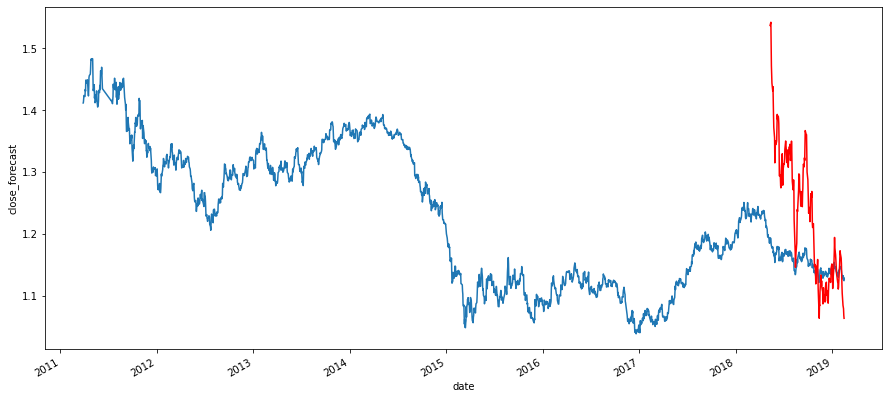


Coefficient alpha= 100
Time've passed 0:00:00.010000
[1.53527438 1.54029657 1.50739839 1.47041093 1.45644817 1.44276701
 1.4305509  1.43682025 1.40864607 1.39007561 1.37175363 1.35519833
 1.31468815 1.3153348  1.34961967 1.34375241 1.34737159 1.35016218
 1.37378855 1.39196195 1.3843733  1.3893957  1.38558918 1.37704456
 1.34875566 1.29396554 1.29565929 1.29119182 1.27818515 1.27474618
 1.30085429 1.3214026  1.32941946 1.29252159 1.27874789 1.30196572
 1.31343785 1.31271385 1.31535211 1.32129852 1.33629111 1.34940207
 1.34449364 1.33714654 1.32461416 1.31505848 1.33492834 1.3341849
 1.31281896 1.30712806 1.32414662 1.34051866 1.32998798 1.34409101
 1.34300137 1.31840399 1.3345838  1.34903806 1.33746666 1.31261993
 1.28499851 1.27157209 1.27766086 1.28683396 1.2765578  1.22283766
 1.18112815 1.17173072 1.14668159 1.15783836 1.16896504 1.18542665
 1.2174557  1.23891218 1.23581787 1.24467641 1.27106313 1.29566257
 1.29486602 1.29447705 1.27323179 1.25856887 1.24454956 1.24625117
 1.267486

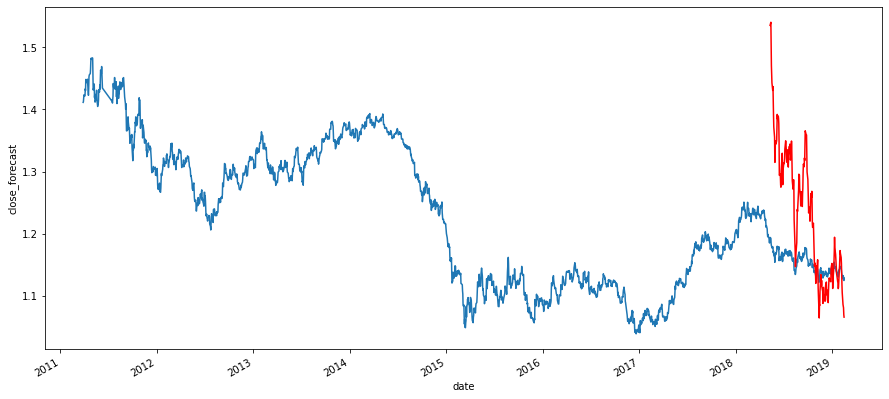


Coefficient alpha= 500
Time've passed 0:00:00.010000
[1.5262609  1.53088044 1.49833489 1.46208865 1.44923623 1.43713346
 1.42550417 1.42992417 1.40166729 1.38510883 1.36840813 1.35403264
 1.31187231 1.31297098 1.34663401 1.34197346 1.34571723 1.34763015
 1.36963928 1.38646273 1.37951868 1.38469021 1.37946989 1.37172987
 1.34655781 1.29400818 1.29752783 1.29137298 1.28017454 1.27592496
 1.30050604 1.32083792 1.32783367 1.29331499 1.27812755 1.29946582
 1.31339583 1.31185922 1.31522936 1.31899237 1.33388306 1.34613512
 1.34163605 1.33282372 1.32130616 1.31309221 1.33164205 1.33037779
 1.31020575 1.30383924 1.31964469 1.33844448 1.32795877 1.34039816
 1.33997283 1.31694371 1.33277659 1.34457793 1.33362566 1.31059263
 1.2840986  1.27252344 1.27753799 1.2847089  1.27507844 1.21963484
 1.1810457  1.17458215 1.14990157 1.15900522 1.17057016 1.18763325
 1.21622394 1.23755276 1.23409882 1.24139781 1.26799229 1.28963505
 1.2884966  1.28797953 1.26770326 1.25688916 1.24274684 1.24358714
 1.26348

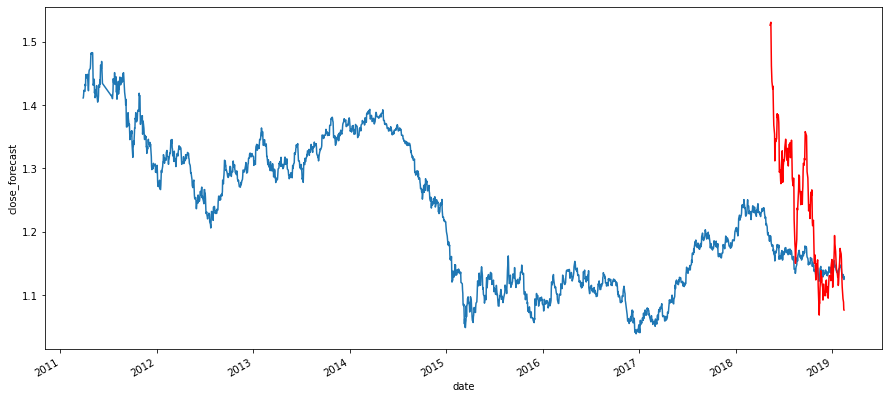


Coefficient alpha= 1000
Time've passed 0:00:00.010000
[1.51548336 1.51982748 1.48784596 1.45275952 1.44096652 1.43007876
 1.41896089 1.42216864 1.39422801 1.37944188 1.36398608 1.35116888
 1.30861301 1.3099299  1.34250463 1.33856146 1.34242965 1.34363235
 1.36422463 1.37998334 1.37338536 1.37869167 1.3725759  1.36558741
 1.34244504 1.29235415 1.29696781 1.28982071 1.2801073  1.27543937
 1.29865667 1.3183852  1.32453561 1.292144   1.27627348 1.29600856
 1.31106375 1.30914421 1.31296082 1.31545105 1.33002307 1.34157259
 1.33724313 1.32763801 1.31704503 1.30991302 1.32741515 1.32580709
 1.30676869 1.30018426 1.3150102  1.33497025 1.32474708 1.33587952
 1.33578549 1.31432258 1.32970631 1.33965094 1.32932099 1.30781528
 1.28274872 1.27253618 1.27690912 1.28274307 1.27351015 1.21799194
 1.18230578 1.17761887 1.15367262 1.16135189 1.17296035 1.18995851
 1.21599864 1.23673331 1.23295338 1.23911614 1.26520733 1.28455563
 1.2831506  1.28258567 1.26335749 1.25529098 1.24136533 1.24169325
 1.2604

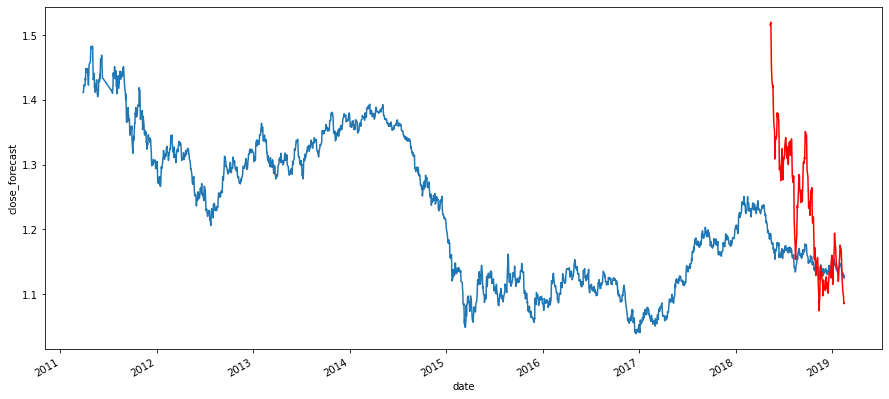


Coefficient alpha= 10000
Time've passed 0:00:00.010000
[1.39942588 1.40193079 1.38183583 1.36093186 1.35510718 1.35000423
 1.34352965 1.34373016 1.32593624 1.31934007 1.31130317 1.30512394
 1.27668677 1.27713873 1.2965153  1.29495974 1.29759392 1.29719681
 1.30813605 1.31689559 1.31311774 1.31693573 1.31151964 1.30826983
 1.29532488 1.26669879 1.27161677 1.26537192 1.26170711 1.25790617
 1.27077041 1.28254601 1.2851277  1.26738985 1.25587242 1.26576954
 1.27729488 1.27564501 1.27909782 1.27894923 1.28785375 1.29441016
 1.29182919 1.28432826 1.27908239 1.27644569 1.28633472 1.28466023
 1.27433554 1.26981383 1.27771551 1.29267992 1.286636   1.29166312
 1.29203176 1.28095589 1.29017956 1.29382098 1.2884405  1.27693696
 1.26339736 1.25914778 1.26106825 1.26294574 1.25735376 1.2211701
 1.2028272  1.20229592 1.18807247 1.19069822 1.19820755 1.20888447
 1.22159808 1.23404889 1.23098469 1.23279732 1.24861847 1.25750689
 1.25628866 1.25590546 1.24514321 1.24445628 1.2360479  1.23526306
 1.2458

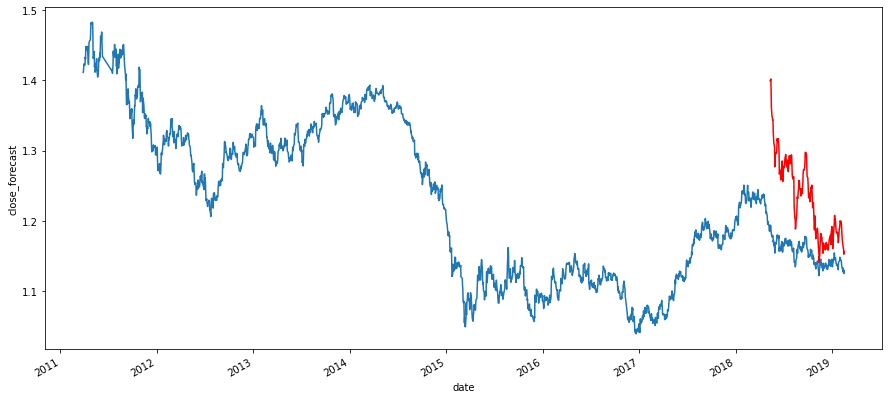


Coefficient alpha= 50000
Time've passed 0:00:00
[1.29116666 1.29205219 1.28486923 1.27750569 1.2755563  1.27387557
 1.27161799 1.27155912 1.26517745 1.26304824 1.2602915  1.25820519
 1.24792689 1.24803595 1.25486388 1.25436666 1.25532137 1.25509934
 1.25885783 1.26190916 1.26059134 1.26200761 1.25996644 1.25889678
 1.2542501  1.24428358 1.24620602 1.24383296 1.24273199 1.2413079
 1.24577904 1.24993708 1.25075284 1.24458251 1.2403846  1.24371743
 1.24796611 1.24736996 1.24870238 1.24853831 1.25169502 1.25398488
 1.25308792 1.25029488 1.24856123 1.24776916 1.25123503 1.25056629
 1.24703119 1.24539111 1.24809514 1.25361713 1.25151399 1.25316997
 1.25330067 1.24956093 1.25281963 1.2539305  1.2521204  1.24815356
 1.24351548 1.24218647 1.24282965 1.24338067 1.24138491 1.22835403
 1.22213595 1.22209673 1.21711168 1.21788884 1.22058598 1.22438512
 1.22864435 1.23303824 1.23188995 1.23238265 1.23796447 1.24089527
 1.24045247 1.24030756 1.23654849 1.23665076 1.23367864 1.23331652
 1.23700755 1.

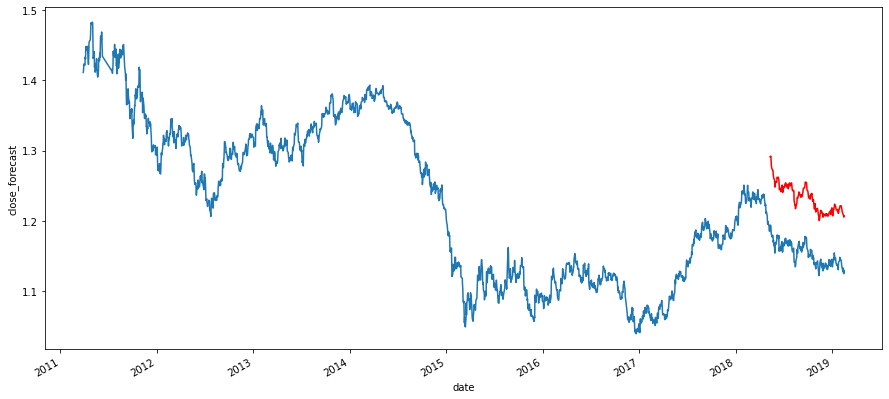


Coefficient alpha= 100000
Time've passed 0:00:00
[1.26492643 1.2654159  1.26143966 1.2573727  1.25630436 1.25538583
 1.25414158 1.25409869 1.25056413 1.24940453 1.2478869  1.24674157
 1.24104342 1.24110049 1.24487203 1.24460115 1.24513087 1.24500198
 1.24707108 1.2487538  1.248027   1.24881548 1.24767771 1.24709302
 1.24451487 1.23902103 1.24009856 1.2387732  1.23818107 1.23738786
 1.23985332 1.24215123 1.2425939  1.23919024 1.23686159 1.23869069
 1.24105178 1.240722   1.24146767 1.24136832 1.2431137  1.24437659
 1.24388284 1.2423274  1.24138036 1.24095388 1.24286742 1.24249075
 1.24054711 1.23963738 1.2411247  1.24419468 1.24303599 1.24394219
 1.24401288 1.24196092 1.24376191 1.24436158 1.24336903 1.24118393
 1.23863293 1.23791302 1.23826648 1.23856223 1.23745744 1.23023566
 1.22682132 1.22681076 1.22406032 1.2244781  1.22597243 1.22807413
 1.23040959 1.23283703 1.23219706 1.2324584  1.23554203 1.23714492
 1.23689972 1.23681842 1.23474367 1.23482845 1.23318545 1.23297868
 1.23501635 

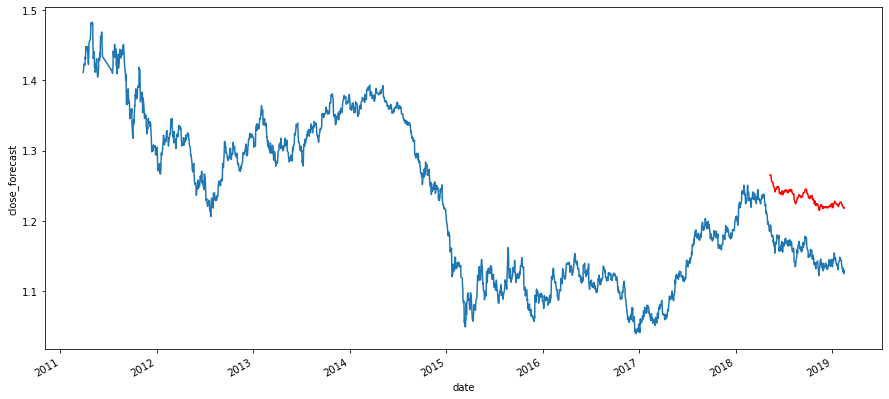

In [22]:
for alpha in alpha_list:
    start_time = datetime.datetime.now()
    
    clf = Ridge(alpha=alpha, random_state=241)
    clf.fit(X_train, y_train_lineral)
    
    #scores.append(cross_val_score(estimator=clf, X=X_train,y=y_train,scoring="roc_auc"))

    print("\nCoefficient alpha=",alpha)
    print("Time've passed", datetime.datetime.now() - start_time)
    #print("Kross validation score=", scores[-1])
    #print("Mean=", np.mean(scores[-1]))
    print(clf.predict(X_test))
    
    #date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
    
    future = pd.DataFrame(index=df_y_text_dt)
    #future['forecast'] = columns= clf.predict(X_test)
    future['forecast'] = clf.predict(X_test)
    
    plt.figure(figsize(15,7))
    df.close.plot()
    future['forecast'].plot(color='r')
    plt.ylabel('close_forecast')
    pylab.show()